# Evaluating A/B Test Data using T-Tests

Earlier in this lesson we introduced you to AB tests, an experimentation method for comparing two groups.  But what does it mean to 'compare' two groups?  If one group has a mean of 20 and one has a mean of 35, is that difference meaningful or the result of random chance?

To answer this question, we need three pieces of information:

1. Summaries of the central tendency for each group- generally the *means*.
2. The amount of variability in each group- generally the *standard deviations*.
3. The size of each group (*N*).

We use the standard deviations and the Ns to put the size of the difference between the group means into context.  The more noisy the groups are (higher sds), the larger a difference between them must be for us to be confident it is a real difference and not the result of the noise.  On the other hand, larger groups (higher Ns) give us more accurate means (means that are more likely to represent the population), reducing noise and letting us detect smaller group differences.

A **t-test** is a statistical test that calculates the size of the difference between two means given their variance and sample size.  The formula is:

$$t = \frac{\bar{y_1}-\bar{y_2}}{\sqrt{s^2_1/N_1+s^2_2/N_2}}$$

$\bar{y_1}$ and $\bar{y_2}$ represent the sample means of groups 1 and 2.

$s_1$ and $s_2$ represent the sample standard deviations of groups 1 and 2.

$N_1$ and $N_2$ represent the sample sizes for groups 1 and 2.

The top of the formula is pretty easy- mean of group 1 minus the mean of group 2.  That's the number we are interested in understanding.  The bottom part is a little less obvious.  In it, we compute the sum of each group's squared standard deviation divided by sample size.  We then take the square root of that value.  (If you're wondering why we square the SDs but then take their square root soon after, refer back to the Central Limit Theorem discussion in the fundamentals course-- the short answer is that it decreases bias in estimates.)

Finally, we divide the top (difference in means) by the bottom (variability over sample size) to get the relative size of the difference in means given the amount of noise in the data.  This is called the t-value.  Larger t-values mean that the difference between the groups is less likely to be due to noise.

Let's see this concept in action with some simulated data.  We'll be comparing two group means (20 and 35) but varying the standard deviations and sample sizes for the groups.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#Keeping the random data the same over multiple runs of the code.
np.random.seed(42)

#Storing our randomly generated data and labels.
data = []
groups = []
labels_var = []
labels_size = []

#The values we use for the standard deviations and the sample sizes.
variability = [5, 20, 50]
sizes = [10, 100, 10000]

#Generating data for each group for each combination of variability and sample size.
for var in variability:
    for size in sizes:
        data.extend(np.random.normal(20,var,size))
        data.extend(np.random.normal(35,var,size))
        labels_var.extend([var]*size*2)
        labels_size.extend([size]*size*2)
        groups.extend(['group1']*size)
        groups.extend(['group2']*size)


In [2]:
#Putting the data together in a data frame and checking it.

data = pd.DataFrame({'data': data, 
                     'groups' : groups,
                    'variability':labels_var,
                    'size':labels_size})
print(data.head())



        data  groups  size  variability
0  22.483571  group1    10            5
1  19.308678  group1    10            5
2  23.238443  group1    10            5
3  27.615149  group1    10            5
4  18.829233  group1    10            5


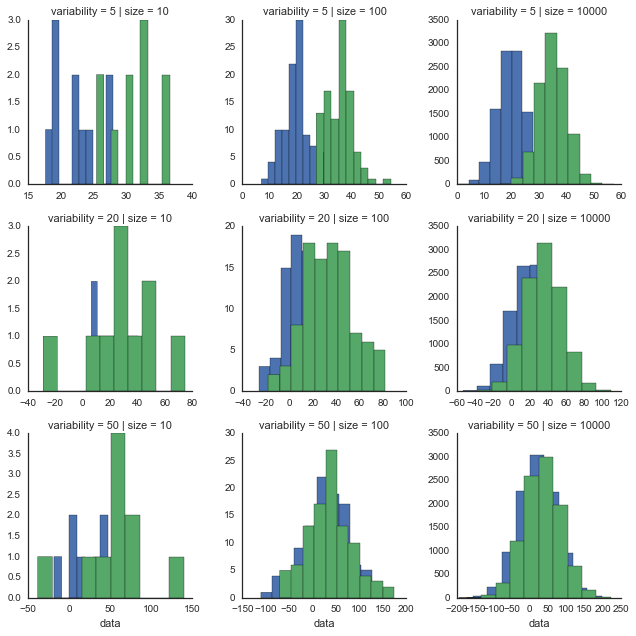

In [3]:
# Plotting the data.  
# Because we organized the data frame in a stacked (long) format, the plotting code is very straightforward.
sns.set_style('white')

g = sns.FacetGrid(data, col="size", row="variability", hue='groups', sharex=False, sharey=False)
g.map(plt.hist,'data')
plt.show()

# Looking at the data

So now we've simulated a bunch of data.  Looking at the plots above, you will notice that it is organized with each column representing a certain sample size (10, 100, or 10000) and each row representing a variability (5, 20, 50).  Notice how, as variance gets larger (staying in the same column and comparing down rows) it gets harder and harder to tell the means apart.   Comparing within a row, however, it is clear that regardless of variance, larger sample sizes make it easier to tell the means apart.  Even when the variance is at its highest (variance = 50), it is possible to discern two distinct peaks when the sample size is 10000 (lower right corner graph).

Now let's calculate t-tests for each of these plots.  The t-test statistic provides a one-number summary of the information in the plot above.  Rather than squinting at two overlapping probability distributions and trying to intuit whether they are different, we can use hard numbers:

In [4]:
# Setting the three non-data columns to work as multi-indices. 
# This makes it much easier to get subsections of stacked data.
data_test = data.set_index(['groups','size','variability'])

# Storing our t-values and p-values (we'll get to p-values in a sec).
tvalues=[]
pvalues=[]

#For each combination of sample size and variability, compare the two groups using a t-test
for size in sizes:
    for var in variability:
        a = data_test['data'].xs(('group1',size,var),level=('groups','size','variability'))
        b = data_test['data'].xs(('group2',size,var),level=('groups','size','variability'))
        tval,pval=stats.ttest_ind(b, a,equal_var=True)
        tvalues.append(tval)
        pvalues.append(pval)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/generic.py:1765: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self.ix[indexer]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:796: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_lowerdim(tup)


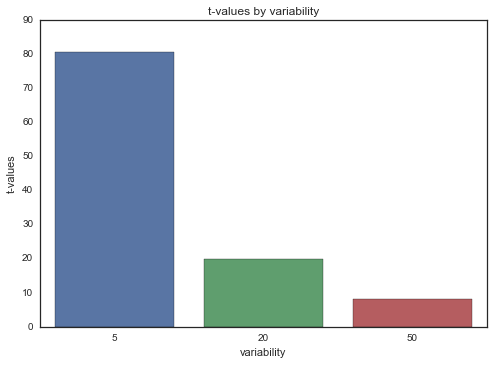

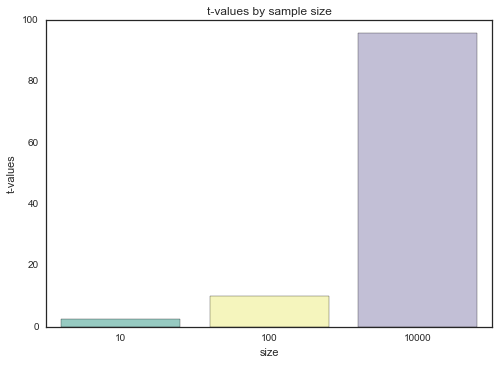

In [5]:
#Creating a data frame for plotting purposes.
tvalues_plot=pd.DataFrame({'t':tvalues,
                           'p':pvalues,
                          'variability':variability*3,
                          'size':np.repeat(sizes,3)})

# t-values by variability
ax = sns.barplot(y='t',x='variability',ci=None,data=tvalues_plot)
ax.set(ylabel='t-values',title='t-values by variability')
plt.show()

# t-values by sample size
ax = sns.barplot(y='t',x='size',ci=None,data=tvalues_plot,palette='Set3')
ax.set(ylabel='t-values',title='t-values by sample size')
plt.show()

# T-tests and AB testing: Two Great Tastes That Taste Great Together

AB testing and T-tests go together like a hammer and a nail.  Alone, neither is worth much, but put them together and you're ready to build something (or at least attach something to a wall).  

Without a t-test or something like it, we would have no straightforward way to use our AB test data to get at the question we really care about: 'Are the groups different?'

With a t-test we calculate the t-statistic, which gives us the size of the group difference divided by the noise level of the data.  Bigger t-values signal a group difference large enough to be interesting to us.

But what is a 'bigger' t-value?  Haven't we just traded one comparison problem (are these means meaningfully different) for another (is this t-value meaningfully large)?  

Another way to phrase the second question is to ask 'What is the probability of getting a t-value this extreme or more so *if there were no difference between the groups in the population*?'  We can decide how improbable we need our t-value to be before we accept that there is a real difference between the two groups.  The probability we refer to is called a **p-value**, and the threshold of improbability we choose is called a **significance level**.  

We'll dive into p-values in depth in the next two assignments.  Before you move on, however, make sure you are **solid** on the logic behind t-tests and how they use variability and sample size information to give us insight into the meaning of our mean differences.  Using variability as a metric to evaluate the meaningfulness of patterns in data is a fundamental theme in statistics.  Talk with your mentor until you feel comfortable with these ideas, then move ahead.

# DRILL: Signals and noise

To help you find your bearings with regard to t-tests, calculate the t-values for the following numbers:

1. $\bar{y_1}= 5$, $\bar{y_2}= 8$, $s_1= 1$, $s_2= 3$, $N_1= 200$, $N_2= 500$
2. $\bar{y_1}= 1090$, $\bar{y_2}= 999$, $s_1= 400$, $s_2= 30$, $N_1= 900$, $N_2= 100$
3. $\bar{y_1}= 45$, $\bar{y_2}= 40$, $s_1= 45$, $s_2= 40$, $N_1= 2000$, $N_2= 2000$

In [ ]:
def ttest(y1, y2, s1, s2, n1, n2):
    return (y1 - y2)/((s1**2 / n1) + (s2**2 / ))

In [6]:
# Answers

1 = -19.7814
2 = 6.6585
3 = 3.7139 

SyntaxError: can't assign to literal (<ipython-input-6-c6991df417f6>, line 3)